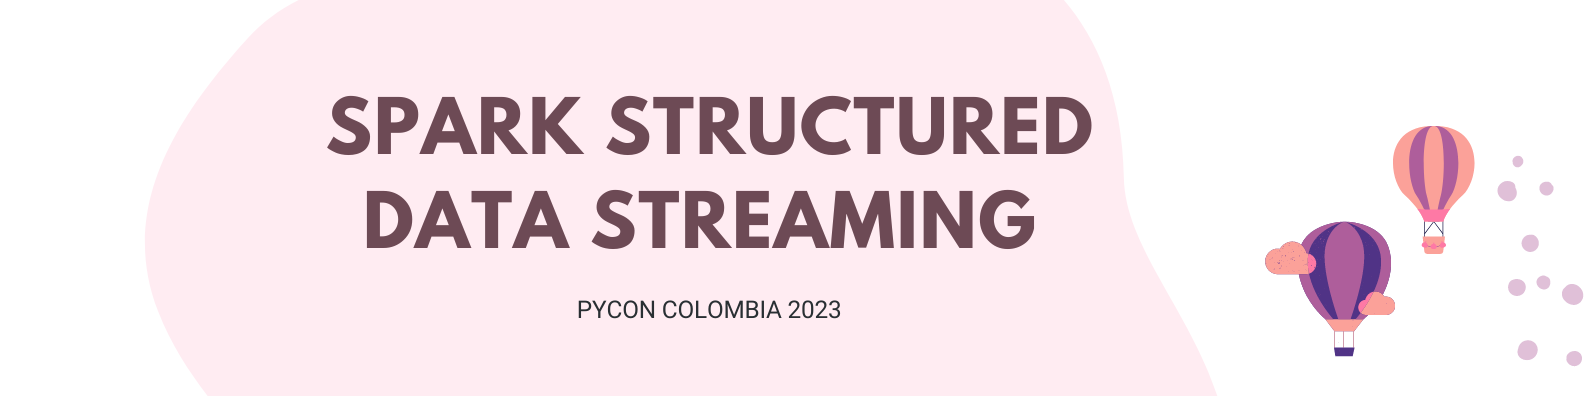

# **1. Crear Reddit App**

Ingresa a https://www.reddit.com/prefs/apps y crea tu App para tener acceso a la API.

![pictureAPI](https://drive.google.com/uc?export=view&id=1DobGduiERNAvum72JTmWwpBSYmfZ8k6Y)

Luego llena los campos obligatorios, establece un nombre y descripción.
![picture](https://drive.google.com/uc?export=view&id=1dmzK6chKQPFTu3L7D2OUnx8MljBWVJ3j)

Finalmente, guarda los siguientes datos que se usarán para autenticarnos (CLIENT ID & CLIENT SECRET)

![picture](https://drive.google.com/uc?export=view&id=1iN1vn31EltYaFK1CH21lXhU71Y1Eek2g)

# **2. Instalación de librerías**
***Praw***: Python Reddit API Wrapper, es un paquete de Python que permite un acceso simple a la API de Reddit. https://praw.readthedocs.io/en/stable/


In [ ]:
!pip install pyspark praw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import praw

# **3. Creación de la sesión de Spark**

In [ ]:
spark = SparkSession.builder \
    .appName("Reddit API Streaming") \
    .getOrCreate()

# **4. Conexión a la API de Reddit**
* ***Username***: Tu usuario de acceso a Reddit 
* ***Password***: Guarda la contraseña en un archivo de texto y cárgalo en el notebook.
* ***ClientId***: El Id guardo del paso 1.
* ***ClientSecret***: El Id guardo del paso 1.

In [ ]:
USERNAME = '<ESCRIBE AQUÍ TU USUARIO DE REDDIT>'
with open('pass.txt','r') as f:
  PASSWORD = f.read()

In [ ]:
reddit = praw.Reddit(
        client_id='<ESCRIBE AQUÍ TU PERSONAL USER SCRIPT>',
        client_secret='<ESCRIBE AQUÍ TU SECRET>',
        user_agent='PrawTut',
        username=USERNAME,
        password=PASSWORD,
        check_for_async=False
    )

# **5. Creación de Streaming df (ReadStream)**

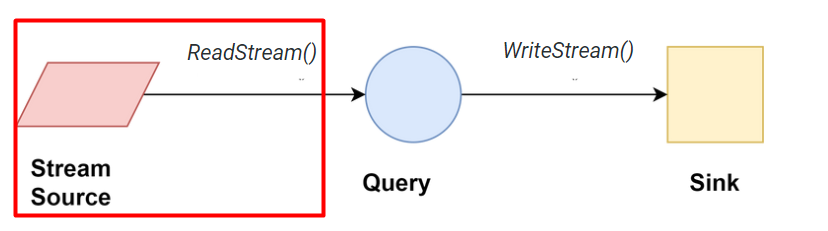

Se establece el esquema con el que se quiere el dataframe

In [ ]:
schema = "title STRING, author STRING, post_id STRING"

In [ ]:
streaming_df = spark.readStream \
    .format("rate") \
    .option("rowsPerSecond", 1) \
    .load()

In [ ]:
streaming_df.isStreaming

True

In [ ]:
subreddit = "python"
limit = 100

In [ ]:
@udf("array<struct<title: string, author: string, post_id: string>>")
def get_reddit_data():
    subreddit_data = reddit.subreddit(subreddit).new(limit=limit)
    data = [(post.title, post.author.name, post.id) for post in subreddit_data]
    return data 

Aplicamos algunas transformaciones para organizar el dataframe

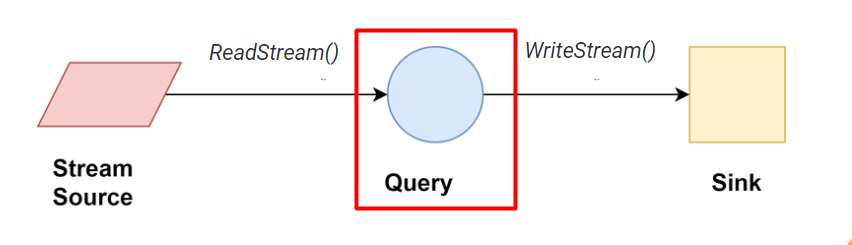

In [ ]:
transformed_df = streaming_df.select(get_reddit_data().alias("reddit_data")) \
                             .selectExpr("explode(reddit_data) as reddit_data")

final_df = transformed_df.select("reddit_data.title", "reddit_data.author", "reddit_data.post_id")

In [ ]:
final_df.isStreaming

True

Verificamos el esquema

In [ ]:
final_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- post_id: string (nullable = true)



# **6. Write Stream al Content de Google**

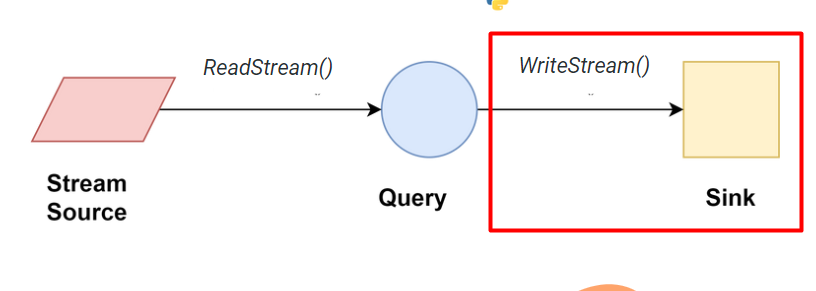

In [ ]:
def process_batch(df, batch_id):
  df.write.option("header",True).mode("append").csv("Resultados_finales/")

In [ ]:
final_df.writeStream \
    .foreachBatch(process_batch) \
    .start()\
    .awaitTermination()